In [1]:
import pulp
import numpy as np


def l2_distance(x1,x2):
    ssq = np.sum(np.square(np.array(x1) - np.array(x2)))
    return ssq

#def l2_distance(point1, point2):
#    return sum([(float(i)-float(j))**2 for (i,j) in zip(point1, point2)])


class subproblem(object):
    def __init__(self, centroids, data, min_size, max_size):

        self.centroids = centroids
        self.data = data
        self.min_size = min_size
        self.max_size= max_size
        self.n = len(data)
        self.k = len(centroids)

        self.create_model()

    def create_model(self):
        def distances(assignment):
            return l2_distance(self.data[assignment[0]], self.centroids[assignment[1]])

        clusters = list(range(self.k))
        assignments = [(i, j)for i in range(self.n) for j in range(self.k)]

        self.y = pulp.LpVariable.dicts('Clustering',
                                  assignments,
                                  lowBound=0,
                                  upBound=1,
                                  cat=pulp.LpInteger)

        self.b = pulp.LpVariable.dicts('Clusterausgabe',
                                  clusters,
                                  lowBound=0,
                                  upBound=self.n-self.min_size,
                                  cat=pulp.LpContinuous)

        # create the model
        self.model = pulp.LpProblem("Subproblemmodell", pulp.LpMinimize)

        # objective function
        self.model += pulp.lpSum([distances(assignment) * self.y[assignment] for assignment in assignments])

        # flow balance constraints for data nodes
        for i in range(self.n):
            self.model += pulp.lpSum(self.y[(i, j)] for j in range(self.k)) == 1

        # flow balance constraints for cluster nodes
        for j in range(self.k):
            self.model += pulp.lpSum(self.y[(i, j)] for i in range(self.n)) - self.min_size == self.b[j]
            
        # capacity constraint on outflow of cluster nodes
        for j in range(self.k):
            self.model += self.b[j] <= self.max_size - self.min_size 

        # flow balance constraint for the sink node
        self.model += pulp.lpSum(self.b[j] for j in range(self.k)) == self.n - (self.k * self.min_size)


    def solve(self):
        self.status = self.model.solve()

        clusters = None
        if self.status == 1:
            clusters= [-1 for i in range(self.n)]
            for i in range(self.n):
                for j in range(self.k):
                    if self.y[(i, j)].value() > 0:
                        clusters[i] = j
        #print(clusters)
        return clusters

def initialize_centers(dataset, k):
    ids = list(range(len(dataset)))
    np.random.shuffle(ids)
    return [dataset[id] for id in ids[:k]]

def compute_centers(clusters, dataset):
    # canonical labeling of clusters
    ids = list(set(clusters))
    c_to_id = dict()
    for j, c in enumerate(ids):
        c_to_id[c] = j
    for j, c in enumerate(clusters):
        clusters[j] = c_to_id[c]

    k = len(ids)
    dim = len(dataset[0])
    centers = [[0.0] * dim for i in range(k)]
    counts = [0] * k
    for j, c in enumerate(clusters):
        for i in range(dim):
            centers[c][i] += dataset[j][i]
        counts[c] += 1
    for j in range(k):
        for i in range(dim):
            centers[j][i] = centers[j][i]/float(counts[j])
    return clusters, centers

def minsize_kmeans(dataset, k, min_size=0, max_size=None):
    n = len(dataset)
    if max_size == None:
        max_size = n

    centers = initialize_centers(dataset, k)
    clusters = [-1] * n

    converged = False
    while not converged:
        m = subproblem(centers, dataset, min_size, max_size)
        clusters_ = m.solve()
        if not clusters_:
            return None, None
        clusters_, centers = compute_centers(clusters_, dataset)

        converged = True
        i = 0
        while converged and i < len(dataset):
            if clusters[i] != clusters_[i]:
                converged = False
            i += 1
        clusters = clusters_

    return clusters, centers

def cluster_quality(cluster):
    if len(cluster) == 0:
        return 0.0

    quality = 0.0
    for i in range(len(cluster)):
        for j in range(i, len(cluster)):
            quality += l2_distance(cluster[i], cluster[j])
            
    return quality / len(cluster)

def compute_quality(data, cluster_indices):
    clusters = dict()
    for i, c in enumerate(cluster_indices):
        if c in clusters:
            clusters[c].append(data[i])
        else:
            clusters[c] = [data[i]]
    return sum(cluster_quality(c) for c in clusters.values())

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
print("Version of Pandas:",pd.__version__)
print("Version of GeoPandas:",gpd.__version__)
print("Version of numpy:",np.__version__)
print("Version of pulp:",pulp.__version__)
print("Version of random: same as python!") # has no version by itself.

Version of Pandas: 1.0.3
Version of GeoPandas: 0.6.1
Version of numpy: 1.18.1
Version of pulp: 2.5.0
Version of random: same as python!


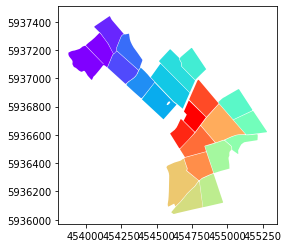

In [3]:
fields = gpd.read_file("C:\\Users\\Jens Harbers\\Documents\\skizzen\\gfn_schlaege.shp")
fields.crs = "epsg:25832"
my_fields = fields[fields.OBJEKT_ID<300]
my_fields.plot(column='OBJEKT_ID', cmap = "rainbow")

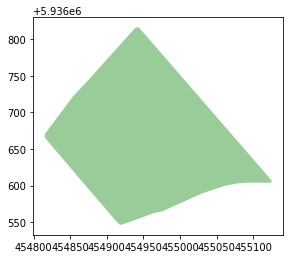

In [4]:
# pick a piece of land for simulation

my_field = my_fields[my_fields.OBJEKT_ID==170]
my_field.plot(color="green",alpha=0.4)

In [5]:
print(my_field.area)
# my_field.bounds #to get maximum extensions in both directions


0    42601.660758
dtype: float64


In [6]:
# simulate bales position using uniform distribution
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

##x = np.arange(0,my_field.bounds.maxx.values - my_field.bounds.minx.values,22) + my_field.bounds.minx.values
##y = np.arange(0,my_field.bounds.maxy.values - my_field.bounds.miny.values,15) + my_field.bounds.miny.values

x = np.arange(0,300,22) + my_field.bounds.minx.values
y = np.arange(0,250,15) + my_field.bounds.miny.values

xx,yy = np.meshgrid(x,y,sparse=False)

rs = RandomState(MT19937(SeedSequence(27438745)))
xx = rs.random(xx.shape) * 15 + xx
yy = rs.random(xx.shape) * 2 + yy

sim_x = xx.reshape(-1)
sim_y = yy.reshape(-1)
bales_groups = pd.DataFrame({"coords_x":sim_x,"coords_y":sim_y})

In [7]:

my_field.bounds.miny.values
#my_field.bounds.minx.values

array([5936546.11765098])

In [8]:
# use only those bales which are on piece of land (remove all other)
gdf = gpd.GeoDataFrame(
    bales_groups, geometry=gpd.points_from_xy(bales_groups.coords_x, bales_groups.coords_y))
gdf.crs = "epsg:25832"

gdf = gdf[["coords_x","coords_y","geometry"]]

join_bales_land = gpd.sjoin(gdf,my_field)

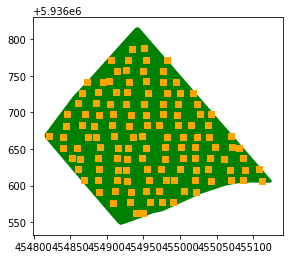

In [9]:
#plot the bales on the land
from matplotlib import pyplot as plt
ax = my_field.plot(color="green")
join_bales_land.plot(color="orange",ax = ax,marker="s")
# plt.close()

In [14]:
best = None
best_clusters = None
NUM_ITER = 11
min_size=1
max_size=8 # maximum number of bales per round
data=join_bales_land[["coords_x","coords_y"]].to_numpy()
nbales=len(data)
print(f"number of bales on land: {nbales}")


number of bales on land: 127


In [15]:
# join_bales_land.to_csv("Ballen_9_jueck.csv",sep=";")

In [16]:
# %%timeit
best = None
best_clusters = None
NUM_ITER = 11
min_size=1
max_size=8 # maximum number of bales per round
data=join_bales_land[["coords_x","coords_y"]].to_numpy()
nbales=len(data)
print(f"number of bales on land: {nbales}")

k = np.ceil(nbales/max_size).astype(int) # round to the higher number and coerce it
                                         # from float to integer
print(f"number of rounds: {k}")
for i in range(NUM_ITER):
    clusters, centers = minsize_kmeans(data, k, min_size, max_size)
    if clusters:
        quality = compute_quality(data, clusters)
        if not best or (quality < best):
            best = quality
            best_clusters = clusters
        if best:
            #print('cluster assignments:')
            #for i in range(len(best_clusters)):
            #    print('%d: %d'%(i, best_clusters[i]))
            if i % 10 == 0:
                print(f"root of sum of squared distances: {round(best**0.5,4)}, {i}")
        else:
            print('no clustering found')

number of bales on land: 127
number of rounds: 16


C:\Anaconda\lib\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


root of sum of squared distances: 241.7671, 0
root of sum of squared distances: 238.8198, 10


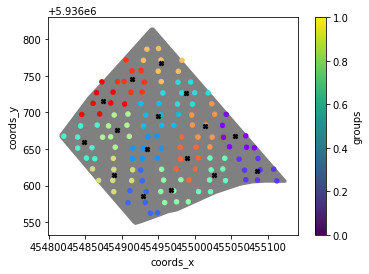

In [17]:
from matplotlib import pyplot as plt
join_bales_land["groups"] = best_clusters
ax = my_field.plot(color="grey", legend=None)
ax = join_bales_land[["coords_x","coords_y","groups"]].plot.scatter(ax=ax,x="coords_x",y="coords_y",c="groups",cmap="rainbow",legend=None)

join_bales_land.groupby("groups").mean()[["coords_x","coords_y"]].plot.scatter(ax=ax,x="coords_x",y="coords_y",c="black",marker="X",legend=None)

In [ ]:
join_bales_land.groupby("groups").mean()[["coords_x","coords_y"]].to_csv("clusterZentren.csv",sep=";")

In [18]:
groups_df = join_bales_land.groupby("groups").mean()[["coords_x","coords_y"]]#.to_csv("clusterZentren.csv",sep=";")

mgd = pd.merge(join_bales_land,groups_df,how="left", left_on="groups",right_on="groups")

dists = np.sqrt((mgd.coords_x_x - mgd.coords_x_y)**2 + (mgd.coords_y_x - mgd.coords_y_y)**2)

mgd["dists"] = dists

mgd.groupby("groups").dists.mean().describe()
#mgd.dists.describe()

mgd.dists.sum()

## Um Gruppenstärke bereinigte Distanz nach Gruppe
(mgd.groupby("groups").dists.sum() / mgd.groupby("groups").dists.count()).to_csv("Gruppendistanzen.csv")

In [ ]:
# mgd.to_csv("ballen_distanzen.csv")

In [19]:
(mgd.groupby("groups").dists.std()).describe()

count    16.000000
mean      7.812188
std       1.356572
min       5.082112
25%       7.103997
50%       8.402078
75%       8.577983
max       9.627184
Name: dists, dtype: float64

In [20]:
mgd.dists.sum()

2516.949421273784